# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Современные методы машинного обучения" </center>

# <center> Лабораторная работа №2. Object Detection. </center>

Выполнил Артём Суворов, 19БИ-3, ИАД-2

Ссылка на этот колаб: [тык](https://colab.research.google.com/drive/1UeW-2NQSbQKAcDOUfjyi7MrfLtDBaEY3?usp=sharing)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data

In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import torchvision.transforms as T

Install library for processing the labeling
```bash
pip install xmltodict
```

In [6]:
!pip install xmltodict

In [7]:
import xmltodict, json

В этом задании потребуется обучить детектор фруктов на изображении. Данные находятся в архиве `data.zip`. Данные уже поделены на train и test.

Датасет для трех классов.

In [9]:
class2tag = {"background": 0, "apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                
                if class2tag[obj["name"]] > 0:
                    labels.append(class2tag[obj["name"]])
                else:
                    labels.append(class2tag['background'])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # # the following code is correct if you use albumentations
            # # if you use torchvision transforms you have to modify it =)
            # res = self.transform(
            #     image=self.images[i],
            #     bboxes=self.annotations[i]["boxes"],
            #     labels=self.annotations[i]["labels"],
            # )
            # return res["image"], {
            #     "boxes": torch.tensor(res["bboxes"]),
            #     "labels": torch.tensor(res["labels"]),
            # }
            annotations = {
                "boxes": torch.tensor(self.annotations[i]["boxes"]),
                "labels": torch.tensor(self.annotations[i]["labels"])
            }

            # does not change bboxes
            # no rotate/flip/crop supported
            img = self.transform(self.images[i])
            return img, annotations
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

<br>  
<br>  
Функции для вычисления mAP.

In [10]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),  # max of x-s
            max(dt_bbox[1], gt_bbox[1]),  # max of y-s
            min(dt_bbox[2], gt_bbox[2]),  # min of x-s
            min(dt_bbox[3], gt_bbox[3]),  # min of y-s
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(intersection_bbox[3] - intersection_bbox[1], 0)
    
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device, iou_threshold=0.5):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true, iou_threshold))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

<br>  
<br>  
  
## Часть 1.  
  
*Вес в общей оценке - 0.4*  
  
В данной части вам нужно решить задачу детектирования фруктов "без классификации". Для этого все три класса нужно объединить в один (нужно внести соотвествующие изменения в датасет).

In [11]:
def get_transform(train=False):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # won't work with bounding boxes
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
fruit_data_train = FruitDataset('/content/drive/MyDrive/data_science/data/train_zip/train', get_transform(train=False))
fruit_data_test = FruitDataset('/content/drive/MyDrive/data_science/data/test_zip/test', get_transform(train=False))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


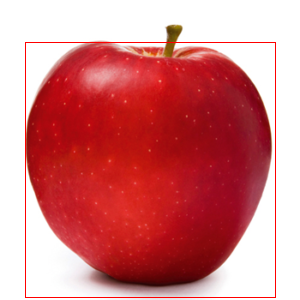

In [13]:
from PIL import ImageDraw

image, labels = next(iter(fruit_data_train))

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=1)
image

In [14]:
fruit_data_train[0][1]['labels'][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1)

Поссмотреть, как делали на семинарах. Там была детекция пешеходов

In [15]:
no_classes = {'background': 0, 'fruit': 1}

class NoClassDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))

                if class2tag[obj["name"]] > 0:
                    labels.append(no_classes['fruit'])
                else:
                    labels.append(no_classes['background'])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # # the following code is correct if you use albumentations
            # # if you use torchvision transforms you have to modify it =)
            # res = self.transform(
            #     image=self.images[i],
            #     bboxes=self.annotations[i]["boxes"],
            #     labels=self.annotations[i]["labels"],
            # )
            # return res["image"], {
            #     "boxes": torch.tensor(res["bboxes"]),
            #     "labels": torch.tensor(res["labels"]),
            # }
            target = {
                "boxes": torch.tensor(self.annotations[i]["boxes"]),
                "labels": torch.tensor(self.annotations[i]["labels"])
            }

            img = self.transform(self.images[i])

            return img, target
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

In [16]:
noclass_data_train = NoClassDataset('/content/drive/MyDrive/data_science/data/train_zip/train', get_transform(train=False))
noclass_data_test = NoClassDataset('/content/drive/MyDrive/data_science/data/test_zip/test', get_transform(train=False))

### Задание 1.  
  
Примените обученные детекторы из [torchvision.models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) - Faster R-CNN, RetinaNet, SSD (можно только с одним backbone, можно все попробовать) - и оцените качество детекции на тестовом датасете. 

In [17]:
from torchvision.models import detection

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

def collate_fn(batch):
    return tuple(zip(*batch))

noclass_data_loader_train = torch.utils.data.DataLoader(noclass_data_train, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
noclass_data_loader_test = torch.utils.data.DataLoader(noclass_data_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
def get_fasterrcnn_model(num_classes=2, pretrained=True):
    model = detection.fasterrcnn_resnet50_fpn(pretrained)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one with random weights
    model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model.to(device)

fasterrcnn = get_fasterrcnn_model(2)
fasterrcnn.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
image, labels = next(iter(noclass_data_test))

pred = fasterrcnn(image.unsqueeze(0).to(device))[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


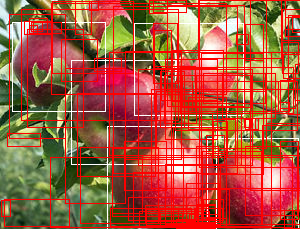

In [21]:
image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

In [22]:
labels['labels'], pred['labels']

(tensor([1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1], device='cuda:0'))

На оригинальной картинке 5 фруктов, необученная модель нашла гораздо больше

In [23]:
evaluate(fasterrcnn, noclass_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.0020445509619311814

Необученная Faster-RCNN имеет очень малую mAP

In [24]:
import math

def get_retinanet_model(num_classes=2, out_channels=256, pretrained=True):
    model = detection.retinanet_resnet50_fpn(pretrained)
    
    # get the number of input features for the classifier
    in_features = model.head.classification_head.conv[0].in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head.num_classes = num_classes

    cls_logits = torch.nn.Conv2d(out_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(cls_logits.weight, std=0.1)
    torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))

    # replace the pre-trained head with a new one  with random weights
    model.head.classification_head.cls_logits = cls_logits

    return model.to(device)

retinanet = get_retinanet_model(2)
retinanet.eval()

evaluate(retinanet, noclass_data_loader_test, device)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth


  0%|          | 0.00/130M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.14995878108766997

Необученная RetinaNet тоже имеет малую mAP

In [25]:
def get_ssd_model(num_classes=2, out_channels=364, pretrained=True):
    model = detection.ssd300_vgg16(pretrained)
    model.head.classification_head.num_classes = num_classes

    # add head for classification with random weights
    cls_logits = torch.nn.Conv2d(out_channels, 9 * num_classes, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(cls_logits.weight, std=0.1)
    torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))
    model.head.classification_head.cls_logits = cls_logits

    # add head for boxes with random weights
    bbox_reg = torch.nn.Conv2d(256, 36, kernel_size=3, stride=1, padding=1)
    torch.nn.init.normal_(bbox_reg.weight, std=0.1)
    torch.nn.init.constant_(bbox_reg.bias, -math.log((1 - 0.01) / 0.01))
    model.head.regression_head.bbox_reg = bbox_reg

    return model.to(device)

ssd = get_ssd_model(2)
ssd.eval()

evaluate(ssd, noclass_data_loader_test, device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

6.212202518964726e-05

Необученная SSD имеет самую меньшую mAP

### Задание 2.  
  
Обучите детекторы из задания выше на обучающем датасете, оцените качество на тестовом. При необходимости, подберите гиперпараметры - optimizer, lr, weight_decay etc.  
Выполните обучение в двух вариантах: со случайной инициализацией весов и с загрузкой весов уже обученной модели. Сравните качество. 

In [26]:
import time

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, num_epochs, train_loader, test_loader, optimizer, device):
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

In [ ]:
fasterrcnn = get_fasterrcnn_model(2)

params = [p for p in fasterrcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.8)
    
train(fasterrcnn, 2, noclass_data_loader_train, noclass_data_loader_test, optimizer, device)

epoch 0/2..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 0.31
Loss value after 20 batches is 0.29
Loss value after 30 batches is 0.27
Loss value after 40 batches is 0.24
Loss value after 50 batches is 0.23
Loss value after 60 batches is 0.21
Loss value after 70 batches is 0.21
Loss value after 80 batches is 0.21
Loss value after 90 batches is 0.21
Loss value after 100 batches is 0.2
Loss value after 110 batches is 0.19
Loss value after 120 batches is 0.18


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 196.89s
mAP after epoch 0 is 0.606:
epoch 1/2..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12
Loss value after 50 batches is 0.13
Loss value after 60 batches is 0.13
Loss value after 70 batches is 0.12
Loss value after 80 batches is 0.12
Loss value after 90 batches is 0.12
Loss value after 100 batches is 0.12
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 195.63s
mAP after epoch 1 is 0.63:


In [ ]:
torch.save(fasterrcnn.state_dict(), '/content/drive/My Drive/data_science/fasterrcnn.pth')

In [27]:
fasterrcnn = get_fasterrcnn_model(2)

if torch.cuda.is_available():
    fasterrcnn.load_state_dict(torch.load('/content/drive/My Drive/data_science/fasterrcnn.pth'))
else:
    fasterrcnn.load_state_dict(torch.load('/content/drive/My Drive/data_science/fasterrcnn.pth', map_location=torch.device('cpu')))
fasterrcnn.eval()

evaluate(fasterrcnn, noclass_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.8426186695930508

Обученная Faster-RCNN имеет уже больший mAP

P.S.: обучение проводилось на GPU, затем модель сохранялась. Выводы написаны после загрузки модели из файла на CPU. Поэтому точность сразу после обучения и после загрузки модели могут отличаться

In [ ]:
retinanet = get_retinanet_model(2)

params = [p for p in retinanet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001, betas=(0.9, 0.999))

train(retinanet, 2, noclass_data_loader_train, noclass_data_loader_test, optimizer, device)

epoch 0/2..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 388.23
Loss value after 20 batches is 194.96
Loss value after 30 batches is 130.49
Loss value after 40 batches is 98.22
Loss value after 50 batches is 78.82
Loss value after 60 batches is 65.87
Loss value after 70 batches is 56.6
Loss value after 80 batches is 49.65
Loss value after 90 batches is 44.22
Loss value after 100 batches is 39.88
Loss value after 110 batches is 36.32
Loss value after 120 batches is 33.36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 200.88s
mAP after epoch 0 is 0.36:
epoch 1/2..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.68
Loss value after 20 batches is 0.66
Loss value after 30 batches is 0.66
Loss value after 40 batches is 0.67
Loss value after 50 batches is 0.66
Loss value after 60 batches is 0.64
Loss value after 70 batches is 0.63
Loss value after 80 batches is 0.62
Loss value after 90 batches is 0.63
Loss value after 100 batches is 0.62
Loss value after 110 batches is 0.62
Loss value after 120 batches is 0.61


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 206.43s
mAP after epoch 1 is 0.496:


In [ ]:
torch.save(retinanet.state_dict(), '/content/drive/My Drive/data_science/retinanet.pth')

In [28]:
retinanet = get_retinanet_model(2)

if torch.cuda.is_available():
    retinanet.load_state_dict(torch.load('/content/drive/My Drive/data_science/retinanet.pth'))
else:
    retinanet.load_state_dict(torch.load('/content/drive/My Drive/data_science/retinanet.pth', map_location=torch.device('cpu')))
retinanet.eval()

evaluate(retinanet, noclass_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.46596217298148246

In [ ]:
ssd = get_ssd_model(2)

params = [p for p in ssd.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.99, 0.999))
    
train(ssd, 2, noclass_data_loader_train, noclass_data_loader_test, optimizer, device)

epoch 0/2..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 12.47
Loss value after 20 batches is 10.83
Loss value after 30 batches is 9.34
Loss value after 40 batches is 8.2
Loss value after 50 batches is 7.51
Loss value after 60 batches is 7.22
Loss value after 70 batches is 6.89
Loss value after 80 batches is 6.52
Loss value after 90 batches is 6.29
Loss value after 100 batches is 6.35
Loss value after 110 batches is 6.24
Loss value after 120 batches is 6.02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 43.34s
mAP after epoch 0 is 0.043:
epoch 1/2..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 3.97
Loss value after 20 batches is 3.83
Loss value after 30 batches is 3.98
Loss value after 40 batches is 3.95
Loss value after 50 batches is 3.94
Loss value after 60 batches is 3.96
Loss value after 70 batches is 4.06
Loss value after 80 batches is 3.98
Loss value after 90 batches is 3.89
Loss value after 100 batches is 3.89
Loss value after 110 batches is 3.88
Loss value after 120 batches is 3.86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 43.03s
mAP after epoch 1 is 0.131:


In [ ]:
torch.save(ssd.state_dict(), '/content/drive/My Drive/data_science/ssd.pth')

In [29]:
ssd = get_ssd_model(2)

if torch.cuda.is_available():
    ssd.load_state_dict(torch.load('/content/drive/My Drive/data_science/ssd.pth'))
else:
    ssd.load_state_dict(torch.load('/content/drive/My Drive/data_science/ssd.pth', map_location=torch.device('cpu')))
ssd.eval()

evaluate(ssd, noclass_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.28113837585947626

А сейчас проверим, какой будет результат у модели со случайной инициализацией весов

In [ ]:
fasterrcnn_not_pretrained = get_fasterrcnn_model(2, pretrained=False)

params = [p for p in fasterrcnn_not_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.8)
    
train(fasterrcnn_not_pretrained, 2, noclass_data_loader_train, noclass_data_loader_test, optimizer, device)

epoch 0/2..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 0.75
Loss value after 20 batches is 0.62
Loss value after 30 batches is 0.51
Loss value after 40 batches is 0.45
Loss value after 50 batches is 0.39
Loss value after 60 batches is 0.36
Loss value after 70 batches is 0.35
Loss value after 80 batches is 0.33
Loss value after 90 batches is 0.33
Loss value after 100 batches is 0.32
Loss value after 110 batches is 0.3
Loss value after 120 batches is 0.3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 199.86s
mAP after epoch 0 is 0.253:
epoch 1/2..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.18
Loss value after 20 batches is 0.17
Loss value after 30 batches is 0.19
Loss value after 40 batches is 0.2
Loss value after 50 batches is 0.19
Loss value after 60 batches is 0.17
Loss value after 70 batches is 0.18
Loss value after 80 batches is 0.19
Loss value after 90 batches is 0.19
Loss value after 100 batches is 0.2
Loss value after 110 batches is 0.21
Loss value after 120 batches is 0.21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 199.29s
mAP after epoch 1 is 0.281:


In [ ]:
torch.save(fasterrcnn_not_pretrained.state_dict(), '/content/drive/My Drive/data_science/fasterrcnn_not_pretrained.pth')

In [30]:
fasterrcnn_not_pretrained = get_fasterrcnn_model(2, pretrained=False)

if torch.cuda.is_available():
    fasterrcnn_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fasterrcnn_not_pretrained.pth'))
else:
    fasterrcnn_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fasterrcnn_not_pretrained.pth', map_location=torch.device('cpu')))
fasterrcnn_not_pretrained.eval()

evaluate(fasterrcnn_not_pretrained, noclass_data_loader_test, device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.3106554676191832

In [ ]:
retinanet_not_pretrained = get_retinanet_model(2, pretrained=False)

params = [p for p in retinanet_not_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)

train(retinanet_not_pretrained, 2, noclass_data_loader_train, noclass_data_loader_test, optimizer, device)

epoch 0/2..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 1.85
Loss value after 20 batches is 1.84
Loss value after 30 batches is 1.84
Loss value after 40 batches is 1.83
Loss value after 50 batches is 1.83
Loss value after 60 batches is 1.82
Loss value after 70 batches is 1.81
Loss value after 80 batches is 1.79
Loss value after 90 batches is 1.77
Loss value after 100 batches is 1.72
Loss value after 110 batches is 1.67
Loss value after 120 batches is 1.63


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 205.25s
mAP after epoch 0 is 0.109:
epoch 1/2..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 1.5
Loss value after 20 batches is 1.59
Loss value after 30 batches is 1.62
Loss value after 40 batches is 1.64
Loss value after 50 batches is 1.67
Loss value after 60 batches is 1.67
Loss value after 70 batches is 1.68
Loss value after 80 batches is 1.67
Loss value after 90 batches is 1.67
Loss value after 100 batches is 1.64
Loss value after 110 batches is 1.61
Loss value after 120 batches is 1.58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 203.58s
mAP after epoch 1 is 0.082:


In [ ]:
torch.save(retinanet_not_pretrained.state_dict(), '/content/drive/My Drive/data_science/retinanet_not_pretrained.pth')

In [31]:
retinanet_not_pretrained = get_retinanet_model(2, pretrained=False)

if torch.cuda.is_available():
    retinanet_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/retinanet_not_pretrained.pth'))
else:
    retinanet_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/retinanet_not_pretrained.pth', map_location=torch.device('cpu')))
retinanet_not_pretrained.eval()

evaluate(retinanet_not_pretrained, noclass_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.18730614613257957

In [ ]:
ssd_not_pretrained = get_ssd_model(2, pretrained=False)

params = [p for p in ssd_not_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.002, betas=(0.99, 0.999))

train(ssd_not_pretrained, 2, noclass_data_loader_train, noclass_data_loader_test, optimizer, device)

epoch 0/2..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 423.72
Loss value after 20 batches is 225.39
Loss value after 30 batches is 163.4
Loss value after 40 batches is 127.96
Loss value after 50 batches is 104.8
Loss value after 60 batches is 90.07
Loss value after 70 batches is 78.81
Loss value after 80 batches is 70.24
Loss value after 90 batches is 63.13
Loss value after 100 batches is 57.44
Loss value after 110 batches is 52.64
Loss value after 120 batches is 48.64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 43.2s
mAP after epoch 0 is 0.082:
epoch 1/2..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 5.08
Loss value after 20 batches is 5.3
Loss value after 30 batches is 4.92
Loss value after 40 batches is 4.84
Loss value after 50 batches is 4.74
Loss value after 60 batches is 4.67
Loss value after 70 batches is 4.61
Loss value after 80 batches is 4.55
Loss value after 90 batches is 4.4
Loss value after 100 batches is 4.35
Loss value after 110 batches is 4.29
Loss value after 120 batches is 4.28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 42.91s
mAP after epoch 1 is 0.073:


In [ ]:
torch.save(ssd_not_pretrained.state_dict(), '/content/drive/My Drive/data_science/ssd_not_pretrained.pth')

In [32]:
ssd_not_pretrained = get_ssd_model(2, pretrained=False)

if torch.cuda.is_available():
    ssd_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/ssd_not_pretrained.pth'))
else:
    ssd_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/ssd_not_pretrained.pth', map_location=torch.device('cpu')))
ssd_not_pretrained.eval()

evaluate(ssd_not_pretrained, noclass_data_loader_test, device)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot.pth


  0%|          | 0.00/56.1M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.2730394098733203

### Задание 3.  
  
- Для лучшей модели оцените, как меняется качество на тестовых данных при изменении порога IoU.  
- Также добавьте порог для минимального значения score у предсказанных bounding box'ов, таким образом отсеивая предсказания с низким конфиденсом. Оцените, как меняется качество при изменении порога (порог IoU используйте 0.5). 

Лучшей моделью является faster-rccn

In [31]:
map_over_threshold = []

for i in range(1, 10):
    map_over_threshold.append(evaluate(fasterrcnn, noclass_data_loader_test, device, i / 10))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

In [32]:
map_over_threshold

[0.8900553910842695,
 0.8789860161261888,
 0.8720922994785627,
 0.858531687413538,
 0.8426186695930508,
 0.7376902973533925,
 0.641991695709895,
 0.3254963407617712,
 0.016854242137780442]

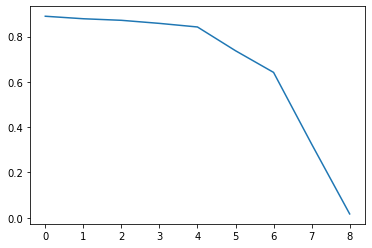

In [33]:
plt.plot(map_over_threshold)

Как можно видеть, точность fatserrcnn уменьшалась с ростом порога IoU

In [33]:
def evaluate_with_score_threshold(model, test_loader, device, iou_threshold=0.5, score_threshold=0.0):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            pred_ = targets_pred[0]

            boxes = pred_['boxes'][pred_['scores'] >= score_threshold]
            labels = pred_['labels'][pred_['scores'] >= score_threshold]
            scores = pred_['scores'][pred_['scores'] >= score_threshold]

            targets_pred = [{
                'boxes': boxes,
                'labels': labels,
                'scores': labels
            }]

            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true, iou_threshold))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [36]:
map_over_score = []

for i in range(1, 10):
    map_score = evaluate_with_score_threshold(fasterrcnn, noclass_data_loader_test, device, 0, i / 10)
    map_over_score.append(map_score)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

In [37]:
map_over_score

[0.44029638745192223,
 0.5227739300905522,
 0.5938120060355647,
 0.6233284337238639,
 0.6437725856422617,
 0.6491101389939642,
 0.6252857546745054,
 0.5873869519461723,
 0.5467895541338095]

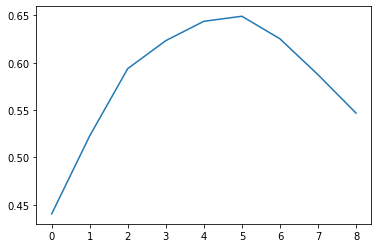

In [38]:
plt.plot(map_over_score)

Чем строже мы отбираем bounding boxes, тем выше точность модели

### Задание 4.  
  
Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета и каких-нибудь картинок из __интернета__ (релевантных - где есть эти фрукты - и тех, где этих фруктов нет).

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

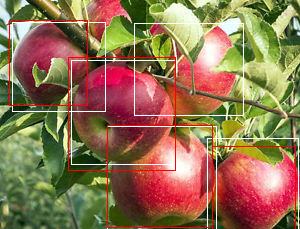

In [39]:
import random

image, labels = None, None

for image_test, annotations_test in noclass_data_loader_test:
    image, labels = image_test[0], annotations_test[0]

    if random.random() > 0.5:
        break

pred = fasterrcnn(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

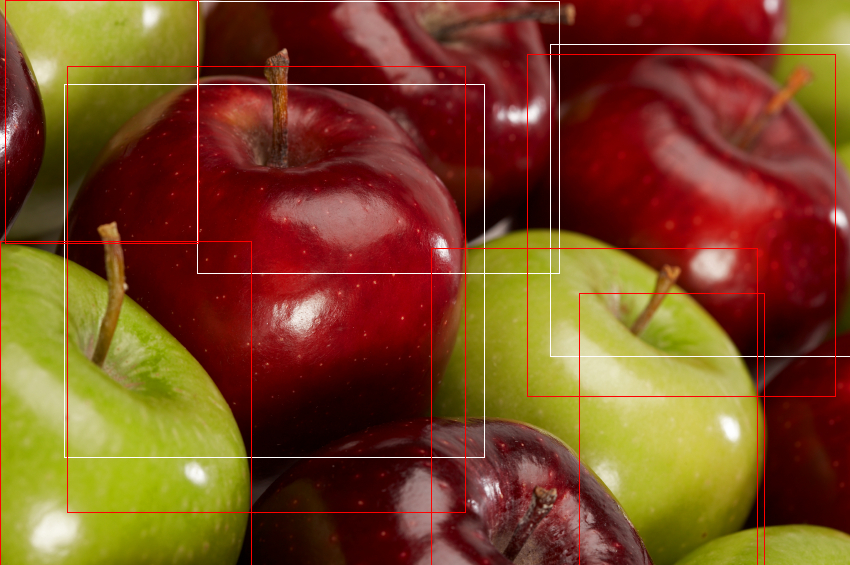

In [52]:
image, labels = None, None

for image_test, annotations_test in noclass_data_loader_test:
    image, labels = image_test[0], annotations_test[0]

    if random.random() < 0.1:
        break

pred = fasterrcnn(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Белая рамка - настоящая детекция. Красная - рамка модели

Как можно видеть, модель довольно неплохо распознаёт фрукты

Попробуем детектировать фрукты по картинке из интернета

In [74]:
from PIL import Image
import requests

toTensor = T.ToTensor()

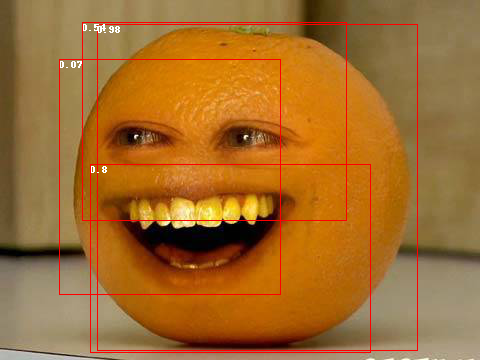

In [42]:
img = Image.open(requests.get('https://i.ytimg.com/vi/ZN5PoW7_kdA/hqdefault.jpg', stream=True).raw)

images = toTensor(img).unsqueeze(0).to(device)

pred = fasterrcnn(images)[0]

draw = ImageDraw.Draw(img)
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()), 2)
    draw.text((box[0], box[1]), f"{str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
img

Как можно видеть, модель почти хорошо распознала апельсин из видео (уверенность в классе "фрукт" - 0.98). Но также распознала много лишнего

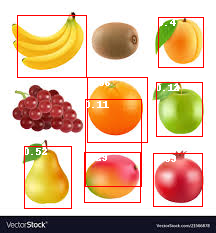

In [43]:
img = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_zZbmqzBgMpxKQqz9kwjKVVkRLSVBmhHJww&usqp=CAU', stream=True).raw)
images = toTensor(img).unsqueeze(0).to(device)

pred = fasterrcnn(images)[0]

draw = ImageDraw.Draw(img)
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
img

Также модель увидела почти все фрукты из другой картинки

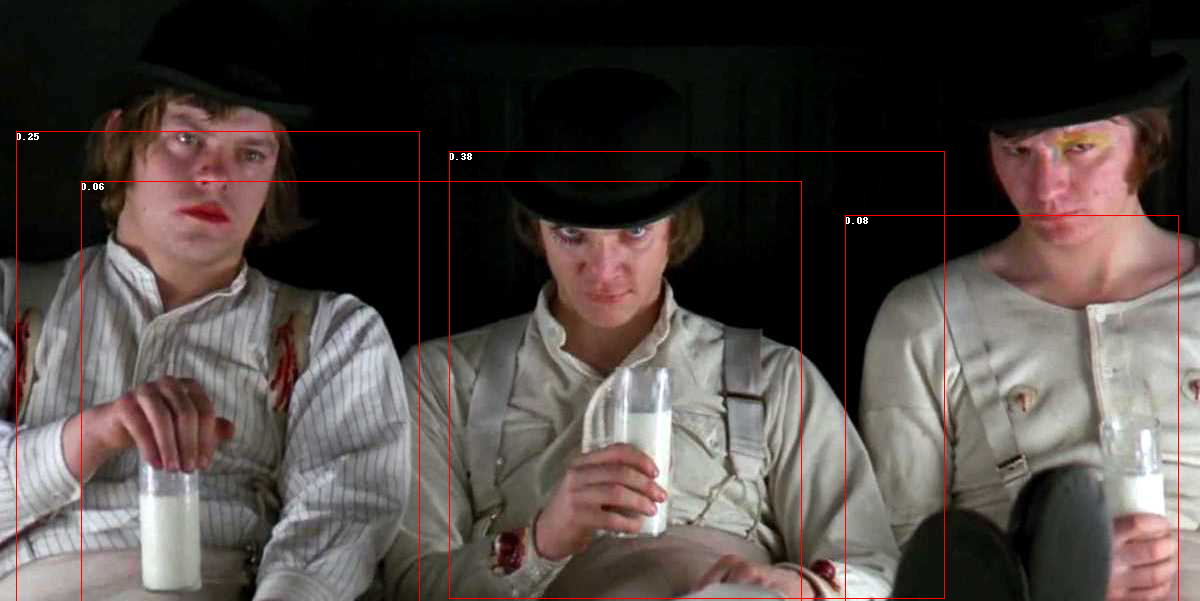

In [44]:
img = Image.open(requests.get('https://styleinsider.com.ua/wp-content/uploads/2020/04/Zavodnoj-apelsin.jpg', stream=True).raw)
images = toTensor(img).unsqueeze(0).to(device)

pred = fasterrcnn(images)[0]

draw = ImageDraw.Draw(img)
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
img

На нерелевантной картинке сеть что-то увидела, но то, что это фрукт, не уверена

### Задание 5.  
  
Реализуйте и примените Non-maximum Suppression. Оцените (визуально и по метрикам), как его использование влияет на качество детекции.   
**NB:** Чтобы продемонстрировать эффективность применения алгоритма, возможно, нужно будет взять достаточно низкий порог конфиденса. 

In [34]:
def nms(P: torch.tensor, scores: torch.tensor, labels: torch.tensor, thresh_iou: float = 0.5):
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    
    order = scores.argsort()

    keep = []
    keep_scores = []
    keep_labels = []

    while len(order) > 0:
        
        idx = order[-1]

        keep.append(P[idx])
        keep_scores.append(scores[idx])
        keep_labels.append(labels[idx])

        order = order[:-1]

        if len(order) == 0:
            break
        
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)

        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])

        w = xx2 - xx1
        h = yy2 - yy1
        
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)

        inter = w*h

        rem_areas = torch.index_select(areas, dim = 0, index = order) 

        union = (rem_areas - inter) + areas[idx]
        
        IoU = inter / union

        mask = IoU < thresh_iou
        order = order[mask]
    
    # convert to traditional tensors
    if keep:
        keep = torch.stack(keep)
    else:
        keep = torch.tensor([])

    return keep, torch.tensor(keep_scores), torch.tensor(keep_labels)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

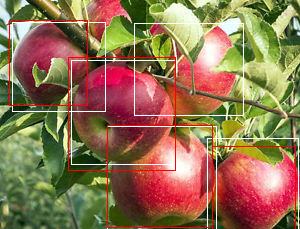

In [46]:
image, labels = None, None

for image_test, annotations_test in noclass_data_loader_test:
    image, labels = image_test[0], annotations_test[0]

    break

pred = fasterrcnn(image.unsqueeze(0).to(device))[0]

pred['boxes'], pred['scores'], pred['labels'] = nms(pred['boxes'], pred['scores'], pred['labels'], 0.2)

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Применение Non-maximum suppression визуально улучшает детекцию. Посмотрим на mAP

In [35]:
def evaluate_nms(model, test_loader, device, iou_threshold=0.5):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            # filterign by NMS
            for i in range(len(targets_pred)):
                targets_pred[i]['boxes'], \
                 targets_pred[i]['scores'], \
                  targets_pred[i]['labels'] = nms(targets_pred[i]['boxes'],
                                                  targets_pred[i]['scores'],
                                                  targets_pred[i]['labels'],
                                                  iou_threshold)

            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true, iou_threshold))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [48]:
evaluate_nms(fasterrcnn, noclass_data_loader_test, device, 0.3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.8462087870076556

Применение Non-maximum Suppression незначительно увеличило точности модели

<br>  
<br>  
  
## Часть 2.  
  
*Вес в общей оценке - 0.4*  
  
Выполните задания 2-5 из предыдущей части для случая 3-х классов (как в изначальном датасете).

In [36]:
fruit_data_loader_train = torch.utils.data.DataLoader(fruit_data_train, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
fruit_data_loader_test = torch.utils.data.DataLoader(fruit_data_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [41]:
fruit_fasterrcnn = get_fasterrcnn_model(4)
fruit_fasterrcnn.eval()

evaluate(fruit_fasterrcnn, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.0009209941477779805

In [42]:
fruit_retinanet = get_retinanet_model(4)
fruit_retinanet.eval()

evaluate(fruit_retinanet, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.006680589824305989

In [43]:
fruit_ssd = get_ssd_model(4)
fruit_ssd.eval()

evaluate(fruit_ssd, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

1.695777278598451e-06

Посмотрим, как ведёт себя лучшая необученная сеть

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


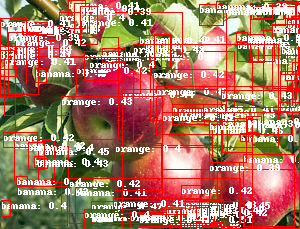

In [44]:
image, labels = next(iter(fruit_data_test))

pred = fruit_fasterrcnn(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

classes = dict((v, k) for k, v in class2tag.items())

for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{classes[int(label.cpu().numpy())]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Пока что модель вообще не понимает, что она делает

Обучим модели

In [ ]:
fruit_fasterrcnn = get_fasterrcnn_model(4)

params = [p for p in fruit_fasterrcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)
    
train(fruit_fasterrcnn, 3, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/3..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 0.71
Loss value after 20 batches is 0.52
Loss value after 30 batches is 0.49
Loss value after 40 batches is 0.44
Loss value after 50 batches is 0.41
Loss value after 60 batches is 0.39
Loss value after 70 batches is 0.38
Loss value after 80 batches is 0.37
Loss value after 90 batches is 0.36
Loss value after 100 batches is 0.35
Loss value after 110 batches is 0.35
Loss value after 120 batches is 0.34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 265.51s
mAP after epoch 0 is 0.666:
epoch 1/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.23
Loss value after 20 batches is 0.2
Loss value after 30 batches is 0.19
Loss value after 40 batches is 0.2
Loss value after 50 batches is 0.21
Loss value after 60 batches is 0.22
Loss value after 70 batches is 0.23
Loss value after 80 batches is 0.23
Loss value after 90 batches is 0.22
Loss value after 100 batches is 0.21
Loss value after 110 batches is 0.21
Loss value after 120 batches is 0.21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 261.47s
mAP after epoch 1 is 0.763:
epoch 2/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.17
Loss value after 20 batches is 0.16
Loss value after 30 batches is 0.18
Loss value after 40 batches is 0.17
Loss value after 50 batches is 0.17
Loss value after 60 batches is 0.16
Loss value after 70 batches is 0.16
Loss value after 80 batches is 0.16
Loss value after 90 batches is 0.16
Loss value after 100 batches is 0.16
Loss value after 110 batches is 0.16
Loss value after 120 batches is 0.17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 259.7s
mAP after epoch 2 is 0.876:


In [ ]:
torch.save(fruit_fasterrcnn.state_dict(), '/content/drive/My Drive/data_science/fruit_fasterrcnn.pth')

In [45]:
fruit_fasterrcnn = get_fasterrcnn_model(4)

if torch.cuda.is_available():
    fruit_fasterrcnn.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_fasterrcnn.pth'))
else:
    fruit_fasterrcnn.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_fasterrcnn.pth', map_location=torch.device('cpu')))
fruit_fasterrcnn.eval()

evaluate(fruit_fasterrcnn, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.8760870304197067

In [ ]:
fruit_retinanet = get_retinanet_model(4)

params = [p for p in fruit_retinanet.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999))
    
train(fruit_retinanet, 3, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/3..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 372.93
Loss value after 20 batches is 188.03
Loss value after 30 batches is 126.18
Loss value after 40 batches is 95.14
Loss value after 50 batches is 76.49
Loss value after 60 batches is 64.03
Loss value after 70 batches is 55.12
Loss value after 80 batches is 48.45
Loss value after 90 batches is 43.23
Loss value after 100 batches is 39.13
Loss value after 110 batches is 35.77
Loss value after 120 batches is 32.91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 276.05s
mAP after epoch 0 is 0.047:
epoch 1/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 1.38
Loss value after 20 batches is 1.35
Loss value after 30 batches is 4.29
Loss value after 40 batches is 6.5
Loss value after 50 batches is 6.76
Loss value after 60 batches is 5.96
Loss value after 70 batches is 5.37
Loss value after 80 batches is 4.94
Loss value after 90 batches is 4.55
Loss value after 100 batches is 4.24
Loss value after 110 batches is 3.98
Loss value after 120 batches is 3.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 274.82s
mAP after epoch 1 is 0.06:
epoch 2/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 1.14
Loss value after 20 batches is 1.18
Loss value after 30 batches is 1.22
Loss value after 40 batches is 1.25
Loss value after 50 batches is 1.28
Loss value after 60 batches is 1.24
Loss value after 70 batches is 1.26
Loss value after 80 batches is 1.26
Loss value after 90 batches is 1.25
Loss value after 100 batches is 1.23
Loss value after 110 batches is 1.23
Loss value after 120 batches is 1.21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 271.13s
mAP after epoch 2 is 0.053:


In [ ]:
torch.save(fruit_retinanet.state_dict(), '/content/drive/My Drive/data_science/fruit_retinanet.pth')

In [46]:
fruit_retinanet = get_retinanet_model(4)

if torch.cuda.is_available():
    fruit_retinanet.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_retinanet.pth'))
else:
    fruit_retinanet.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_retinanet.pth', map_location=torch.device('cpu')))
fruit_retinanet.eval()

evaluate(fruit_retinanet, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.05333453206639177

In [ ]:
fruit_ssd = get_ssd_model(4)

params = [p for p in fruit_ssd.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.99, 0.99))
    
train(fruit_ssd, 3, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/3..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 50.3
Loss value after 20 batches is 30.97
Loss value after 30 batches is 23.7
Loss value after 40 batches is 19.53
Loss value after 50 batches is 16.92
Loss value after 60 batches is 15.12
Loss value after 70 batches is 13.86
Loss value after 80 batches is 12.93
Loss value after 90 batches is 12.15
Loss value after 100 batches is 11.56
Loss value after 110 batches is 11.03
Loss value after 120 batches is 10.61


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 60.31s
mAP after epoch 0 is 0.033:
epoch 1/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 5.66
Loss value after 20 batches is 5.6
Loss value after 30 batches is 5.65
Loss value after 40 batches is 5.79
Loss value after 50 batches is 5.71
Loss value after 60 batches is 5.65
Loss value after 70 batches is 5.67
Loss value after 80 batches is 5.66
Loss value after 90 batches is 5.66
Loss value after 100 batches is 5.64
Loss value after 110 batches is 5.64
Loss value after 120 batches is 5.67


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 60.05s
mAP after epoch 1 is 0.038:
epoch 2/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 5.74
Loss value after 20 batches is 5.69
Loss value after 30 batches is 5.77
Loss value after 40 batches is 5.7
Loss value after 50 batches is 5.57
Loss value after 60 batches is 5.52
Loss value after 70 batches is 5.49
Loss value after 80 batches is 5.47
Loss value after 90 batches is 5.48
Loss value after 100 batches is 5.43
Loss value after 110 batches is 5.44
Loss value after 120 batches is 5.45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 59.88s
mAP after epoch 2 is 0.082:


In [ ]:
torch.save(fruit_ssd.state_dict(), '/content/drive/My Drive/data_science/fruit_ssd.pth')

In [47]:
fruit_ssd = get_ssd_model(4)

if torch.cuda.is_available():
    fruit_ssd.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_ssd.pth'))
else:
    fruit_ssd.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_ssd.pth', map_location=torch.device('cpu')))
fruit_ssd.eval()

evaluate(fruit_ssd, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.08209037466746

Теперь лучшая модель ведёт себя так:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


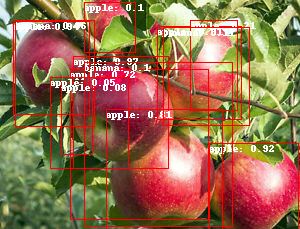

In [48]:
image, labels = next(iter(fruit_data_test))

pred = fruit_fasterrcnn(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

classes = dict((v, k) for k, v in class2tag.items())

for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{classes[int(label.cpu().numpy())]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Модель распознала яблоки, но слишком много

Random initialization

In [ ]:
fruit_fasterrcnn_not_pretrained = get_fasterrcnn_model(4, pretrained=False)

params = [p for p in fruit_fasterrcnn_not_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)
    
train(fruit_fasterrcnn_not_pretrained, 3, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/3..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 1.22
Loss value after 20 batches is 0.83
Loss value after 30 batches is 0.7
Loss value after 40 batches is 0.63
Loss value after 50 batches is 0.6
Loss value after 60 batches is 0.6
Loss value after 70 batches is 0.57
Loss value after 80 batches is 0.56
Loss value after 90 batches is 0.53
Loss value after 100 batches is 0.52
Loss value after 110 batches is 0.5
Loss value after 120 batches is 0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 264.0s
mAP after epoch 0 is 0.025:
epoch 1/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.46
Loss value after 20 batches is 0.47
Loss value after 30 batches is 0.42
Loss value after 40 batches is 0.4
Loss value after 50 batches is 0.4
Loss value after 60 batches is 0.4
Loss value after 70 batches is 0.42
Loss value after 80 batches is 0.41
Loss value after 90 batches is 0.4
Loss value after 100 batches is 0.41
Loss value after 110 batches is 0.41
Loss value after 120 batches is 0.41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 263.62s
mAP after epoch 1 is 0.028:
epoch 2/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.43
Loss value after 20 batches is 0.42
Loss value after 30 batches is 0.41
Loss value after 40 batches is 0.42
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.41
Loss value after 70 batches is 0.41
Loss value after 80 batches is 0.4
Loss value after 90 batches is 0.4
Loss value after 100 batches is 0.41
Loss value after 110 batches is 0.41
Loss value after 120 batches is 0.41


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 264.64s
mAP after epoch 2 is 0.078:


In [ ]:
torch.save(fruit_fasterrcnn_not_pretrained.state_dict(), '/content/drive/My Drive/data_science/fruit_fasterrcnn_not_pretrained.pth')

In [49]:
fruit_fasterrcnn_not_pretrained = get_fasterrcnn_model(4, pretrained=False)

if torch.cuda.is_available():
    fruit_fasterrcnn_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_fasterrcnn_not_pretrained.pth'))
else:
    fruit_fasterrcnn_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_fasterrcnn_not_pretrained.pth', map_location=torch.device('cpu')))
fruit_fasterrcnn_not_pretrained.eval()

evaluate(fruit_fasterrcnn_not_pretrained, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.07788344830663745

In [93]:
fruit_retinanet_not_pretrained = get_retinanet_model(4, pretrained=False)

params = [p for p in fruit_retinanet_not_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.8)

train(fruit_retinanet_not_pretrained, 3, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/3..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 1.84
Loss value after 20 batches is 1.83
Loss value after 30 batches is 1.82
Loss value after 40 batches is 1.82
Loss value after 50 batches is 1.83
Loss value after 60 batches is 1.83
Loss value after 70 batches is 1.83
Loss value after 80 batches is 1.82
Loss value after 90 batches is 1.82
Loss value after 100 batches is 1.81
Loss value after 110 batches is 1.8
Loss value after 120 batches is 1.79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 213.98s
mAP after epoch 0 is 0.023:
epoch 1/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 1.43
Loss value after 20 batches is 1.35
Loss value after 30 batches is 1.3
Loss value after 40 batches is 1.32
Loss value after 50 batches is 1.39
Loss value after 60 batches is 1.43
Loss value after 70 batches is 1.44
Loss value after 80 batches is 1.46
Loss value after 90 batches is 1.46
Loss value after 100 batches is 1.43
Loss value after 110 batches is 1.4
Loss value after 120 batches is 1.38


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 213.29s
mAP after epoch 1 is 0.08:
epoch 2/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 1.06
Loss value after 20 batches is 1.07
Loss value after 30 batches is 1.05
Loss value after 40 batches is 1.05
Loss value after 50 batches is 1.12
Loss value after 60 batches is 1.1
Loss value after 70 batches is 1.09
Loss value after 80 batches is 1.15
Loss value after 90 batches is 1.19
Loss value after 100 batches is 1.21
Loss value after 110 batches is 1.22
Loss value after 120 batches is 1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 214.45s
mAP after epoch 2 is 0.073:


In [94]:
torch.save(fruit_retinanet_not_pretrained.state_dict(), '/content/drive/My Drive/data_science/fruit_retinanet_not_pretrained.pth')

In [95]:
fruit_retinanet_not_pretrained = get_retinanet_model(4, pretrained=False)

if torch.cuda.is_available():
    fruit_retinanet_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_retinanet_not_pretrained.pth'))
else:
    fruit_retinanet_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_retinanet_not_pretrained.pth', map_location=torch.device('cpu')))
fruit_retinanet_not_pretrained.eval()

evaluate(fruit_retinanet_not_pretrained, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.07295720239654006

In [ ]:
fruit_ssd_not_pretrained = get_ssd_model(4, pretrained=False)

params = [p for p in fruit_ssd_not_pretrained.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.99, 0.999))
    
train(fruit_ssd_not_pretrained, 3, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/3..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 81.2
Loss value after 20 batches is 61.31
Loss value after 30 batches is 46.83
Loss value after 40 batches is 45.59
Loss value after 50 batches is 40.75
Loss value after 60 batches is 36.75
Loss value after 70 batches is 33.19
Loss value after 80 batches is 30.43
Loss value after 90 batches is 27.97
Loss value after 100 batches is 25.91
Loss value after 110 batches is 24.19
Loss value after 120 batches is 22.76


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 60.01s
mAP after epoch 0 is 0.047:
epoch 1/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 5.98
Loss value after 20 batches is 5.97
Loss value after 30 batches is 6.05
Loss value after 40 batches is 6.18
Loss value after 50 batches is 6.13
Loss value after 60 batches is 6.07
Loss value after 70 batches is 5.99
Loss value after 80 batches is 6.02
Loss value after 90 batches is 5.99
Loss value after 100 batches is 5.96
Loss value after 110 batches is 5.94
Loss value after 120 batches is 5.94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 60.01s
mAP after epoch 1 is 0.072:
epoch 2/3..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 5.7
Loss value after 20 batches is 5.63
Loss value after 30 batches is 5.48
Loss value after 40 batches is 5.56
Loss value after 50 batches is 5.53
Loss value after 60 batches is 5.47
Loss value after 70 batches is 5.52
Loss value after 80 batches is 5.5
Loss value after 90 batches is 5.51
Loss value after 100 batches is 5.49
Loss value after 110 batches is 5.45
Loss value after 120 batches is 5.43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 59.99s
mAP after epoch 2 is 0.079:


In [ ]:
torch.save(fruit_ssd_not_pretrained.state_dict(), '/content/drive/My Drive/data_science/fruit_ssd_not_pretrained.pth')

In [51]:
fruit_ssd_not_pretrained = get_ssd_model(4, pretrained=False)

if torch.cuda.is_available():
    fruit_ssd_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_ssd_not_pretrained.pth'))
else:
    fruit_ssd_not_pretrained.load_state_dict(torch.load('/content/drive/My Drive/data_science/fruit_ssd_not_pretrained.pth', map_location=torch.device('cpu')))
fruit_ssd_not_pretrained.eval()

evaluate(fruit_ssd_not_pretrained, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.07853054196010016

Обученные с нуля сети не стоит рассматривать - их точность менее 1%

<br>  
<br>  
  
## Часть 3.  
  
*Вес в общей оценке - 0.2*  
  
Обучите модель для object detection для трех классов на __обучающем__ датасете и добейтесь PR AUC не менее __0.91__ на  __тестовом__.  
Баллы за задание вычисляются по формуле: __min(2, 2 * Ваш auc / 0.91)__.

In [96]:
def train_one_epoch_schedule(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # print(targets)

        dict_loss = model(images, targets)

        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train_schedule(model, num_epochs, train_loader, test_loader, optimizer, scheduler, device):
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch_schedule(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()
        scheduler.step()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

In [102]:
# if out of memory - run this

import gc
gc.collect()
torch.cuda.empty_cache()

In [103]:
best_model = get_fasterrcnn_model(4)

params = [p for p in best_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)  # scheduler did not help: mAP after train = 0.45

train(best_model, 10, fruit_data_loader_train, fruit_data_loader_test, optimizer, device)

epoch 0/10..


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Loss value after 10 batches is 0.66
Loss value after 20 batches is 0.52
Loss value after 30 batches is 0.47
Loss value after 40 batches is 0.43
Loss value after 50 batches is 0.42
Loss value after 60 batches is 0.42
Loss value after 70 batches is 0.4
Loss value after 80 batches is 0.39
Loss value after 90 batches is 0.38
Loss value after 100 batches is 0.37
Loss value after 110 batches is 0.36
Loss value after 120 batches is 0.35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 0 done in 208.6s
mAP after epoch 0 is 0.674:
epoch 1/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.29
Loss value after 20 batches is 0.25
Loss value after 30 batches is 0.26
Loss value after 40 batches is 0.24
Loss value after 50 batches is 0.25
Loss value after 60 batches is 0.24
Loss value after 70 batches is 0.24
Loss value after 80 batches is 0.24
Loss value after 90 batches is 0.23
Loss value after 100 batches is 0.23
Loss value after 110 batches is 0.23
Loss value after 120 batches is 0.23


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 1 done in 207.71s
mAP after epoch 1 is 0.803:
epoch 2/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.19
Loss value after 20 batches is 0.19
Loss value after 30 batches is 0.19
Loss value after 40 batches is 0.19
Loss value after 50 batches is 0.19
Loss value after 60 batches is 0.18
Loss value after 70 batches is 0.17
Loss value after 80 batches is 0.17
Loss value after 90 batches is 0.17
Loss value after 100 batches is 0.17
Loss value after 110 batches is 0.17
Loss value after 120 batches is 0.17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 2 done in 206.65s
mAP after epoch 2 is 0.737:
epoch 3/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.1
Loss value after 20 batches is 0.11
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.14
Loss value after 50 batches is 0.14
Loss value after 60 batches is 0.14
Loss value after 70 batches is 0.14
Loss value after 80 batches is 0.14
Loss value after 90 batches is 0.14
Loss value after 100 batches is 0.14
Loss value after 110 batches is 0.14
Loss value after 120 batches is 0.15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 3 done in 209.45s
mAP after epoch 3 is 0.918:
epoch 4/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.16
Loss value after 20 batches is 0.15
Loss value after 30 batches is 0.15
Loss value after 40 batches is 0.14
Loss value after 50 batches is 0.14
Loss value after 60 batches is 0.14
Loss value after 70 batches is 0.13
Loss value after 80 batches is 0.13
Loss value after 90 batches is 0.14
Loss value after 100 batches is 0.14
Loss value after 110 batches is 0.14
Loss value after 120 batches is 0.13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 4 done in 208.92s
mAP after epoch 4 is 0.892:
epoch 5/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.14
Loss value after 20 batches is 0.13
Loss value after 30 batches is 0.12
Loss value after 40 batches is 0.12
Loss value after 50 batches is 0.12
Loss value after 60 batches is 0.12
Loss value after 70 batches is 0.12
Loss value after 80 batches is 0.12
Loss value after 90 batches is 0.12
Loss value after 100 batches is 0.12
Loss value after 110 batches is 0.12
Loss value after 120 batches is 0.11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 5 done in 209.83s
mAP after epoch 5 is 0.916:
epoch 6/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.11
Loss value after 20 batches is 0.1
Loss value after 30 batches is 0.1
Loss value after 40 batches is 0.09
Loss value after 50 batches is 0.1
Loss value after 60 batches is 0.1
Loss value after 70 batches is 0.1
Loss value after 80 batches is 0.1
Loss value after 90 batches is 0.1
Loss value after 100 batches is 0.1
Loss value after 110 batches is 0.1
Loss value after 120 batches is 0.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 6 done in 209.97s
mAP after epoch 6 is 0.893:
epoch 7/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.12
Loss value after 20 batches is 0.11
Loss value after 30 batches is 0.11
Loss value after 40 batches is 0.1
Loss value after 50 batches is 0.1
Loss value after 60 batches is 0.1
Loss value after 70 batches is 0.1
Loss value after 80 batches is 0.1
Loss value after 90 batches is 0.09
Loss value after 100 batches is 0.09
Loss value after 110 batches is 0.09
Loss value after 120 batches is 0.09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 7 done in 206.84s
mAP after epoch 7 is 0.94:
epoch 8/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.09
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.07
Loss value after 40 batches is 0.08
Loss value after 50 batches is 0.07
Loss value after 60 batches is 0.08
Loss value after 70 batches is 0.08
Loss value after 80 batches is 0.08
Loss value after 90 batches is 0.08
Loss value after 100 batches is 0.08
Loss value after 110 batches is 0.08
Loss value after 120 batches is 0.08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 8 done in 210.09s
mAP after epoch 8 is 0.897:
epoch 9/10..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Loss value after 10 batches is 0.08
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.07
Loss value after 40 batches is 0.07
Loss value after 50 batches is 0.07
Loss value after 60 batches is 0.07
Loss value after 70 batches is 0.07
Loss value after 80 batches is 0.07
Loss value after 90 batches is 0.08
Loss value after 100 batches is 0.08
Loss value after 110 batches is 0.08
Loss value after 120 batches is 0.08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

epoch 9 done in 210.7s
mAP after epoch 9 is 0.924:


In [104]:
torch.save(best_model.state_dict(), '/content/drive/My Drive/data_science/best_model.pth')

In [105]:
best_model = get_fasterrcnn_model(4)

if torch.cuda.is_available():
    best_model.load_state_dict(torch.load('/content/drive/My Drive/data_science/best_model.pth'))
else:
    best_model.load_state_dict(torch.load('/content/drive/My Drive/data_science/best_model.pth', map_location=torch.device('cpu')))

best_model.eval()

evaluate(best_model, fruit_data_loader_test, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

0.9244804159881631

In [106]:
map_over_threshold = []

for i in range(1, 10):
    map_over_threshold.append(evaluate(best_model, fruit_data_loader_test, device, i / 10))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

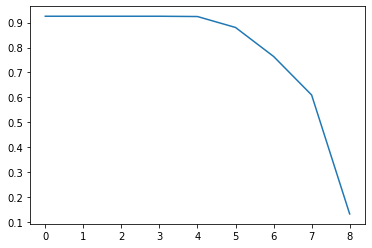

In [107]:
plt.plot(map_over_threshold)

In [ ]:
map_over_score = []

for i in range(1, 10):
    map_score = evaluate_with_score_threshold(best_model, fruit_data_loader_test, device, 0.5, i / 10)
    map_over_score.append(map_score)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

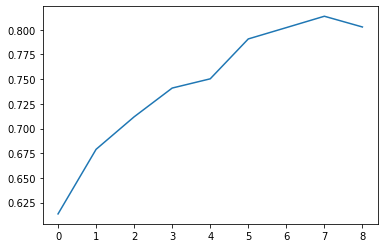

In [110]:
plt.plot(map_over_score)

Теперь посмотрим на реальные примеры

In [79]:
classes = dict((v, k) for k, v in class2tag.items())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


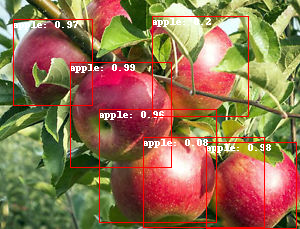

In [80]:
image, labels = next(iter(fruit_data_test))

pred = best_model(image.unsqueeze(0).to(device))[0]

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{classes[int(label.cpu().numpy())]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

Модель распознала все яблоки (даже немного больше)

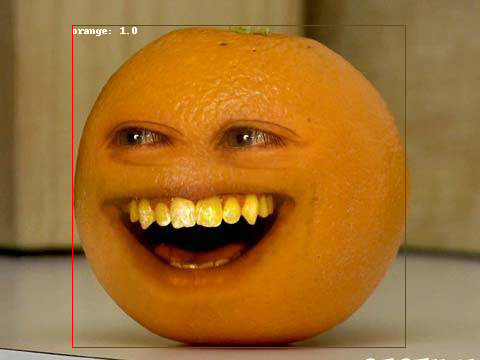

In [83]:
img = Image.open(requests.get('https://i.ytimg.com/vi/ZN5PoW7_kdA/hqdefault.jpg', stream=True).raw)

images = toTensor(img).unsqueeze(0).to(device)

pred = best_model(images)[0]

draw = ImageDraw.Draw(img)

for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{classes[int(label.cpu().numpy())]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
img

Модель однозначно распознала, что это апельсин

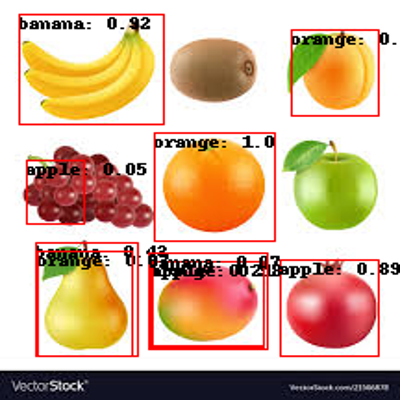

In [86]:
img = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR_zZbmqzBgMpxKQqz9kwjKVVkRLSVBmhHJww&usqp=CAU', stream=True).raw)
images = toTensor(img).unsqueeze(0).to(device)

pred = best_model(images)[0]

draw = ImageDraw.Draw(img)

for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{classes[int(label.cpu().numpy())]}: {str(score)}", fill='#000000')
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')

img.resize((400, 400))

В некоторых местах (при незнакомых фруктах) модель ссылается на похожий фрукт. Но при этом пропустила несколько знакомых

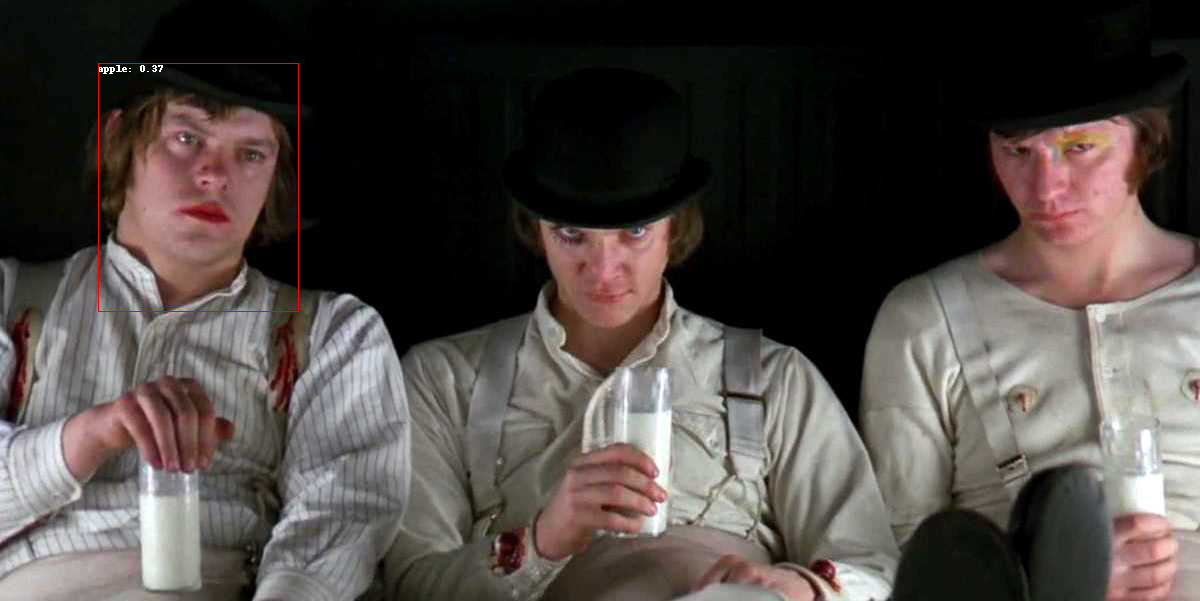

In [88]:
img = Image.open(requests.get('https://styleinsider.com.ua/wp-content/uploads/2020/04/Zavodnoj-apelsin.jpg', stream=True).raw)
images = toTensor(img).unsqueeze(0).to(device)

pred = best_model(images)[0]

draw = ImageDraw.Draw(img)
    
for box, label, score in zip(pred['boxes'], pred["labels"], pred["scores"]):
    score = round(float(score.cpu().detach().numpy()),2)
    draw.text((box[0], box[1]), f"{classes[int(label.cpu().numpy())]}: {str(score)}")
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')

img

Ну а тут можно списать на случайность - тем более вероятность меньше 0.5

<br>  
<br>  
  
## Бонусные задания.  
  
1. При обучении используйте аугментации (в первую очередь пространственные) из [albumentations](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) или [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html).  
2. Возьмите одну из [детекционных архитектур](https://paperswithcode.com/sota/object-detection-on-coco) (желательно, не старее 2020 года), у которой выложены тренировочный код и чекпоинты на гитхабе, обучите и провалидируйте ее на данных этой лабораторной. 